In [1]:
import numpy as np
import pandas as pd
import math
import json
import re
import os
import shutil
from sklearn.model_selection import train_test_split
from jarvis.db.figshare import data
import matplotlib.pyplot as plt
from pymatgen.core.composition import Composition
from pymatgen.core.structure import Structure
from pymatgen.analysis.structure_matcher import StructureMatcher
from jarvis.core.atoms import Atoms
from pymatgen.io.jarvis import JarvisAtomsAdaptor

In [2]:
from jarvis.db.figshare import data

dft_3d = data('dft_3d')
jarvis=pd.DataFrame(dft_3d)

Obtaining 3D dataset 76k ...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Other versions:https://doi.org/10.6084/m9.figshare.6815699
Loading the zipfile...
Loading completed.


In [3]:
junwen=pd.read_pickle('/Users/elena.patyukova/Documents/Junwen-data/junwen_3_july_no_structural_duplicates_kdist_with_supercell.pkl')

## Calculate k_dist for Jarvis

In [4]:
k_dists=[]
structures=[]
for i in range(len(jarvis)):
    try:
        atoms = Atoms.from_dict(jarvis.iloc[i]['atoms'])
        structure = JarvisAtomsAdaptor.get_structure(atoms)
        structures.append(structure)
        rec_lattice = structure.lattice.reciprocal_lattice
        b_lengths = rec_lattice.abc 
        klength=jarvis.iloc[i]['kpoint_length_unit']
        kmesh = [max(1, int(klength * b + 0.5)) for b in b_lengths]
        k_dist=max(b / n for b, n in zip(b_lengths, kmesh))
        k_dists.append(k_dist)
    except:
        k_dists.append(np.nan)

In [5]:
jarvis['k_dist']=k_dists
jarvis['structure']=structures

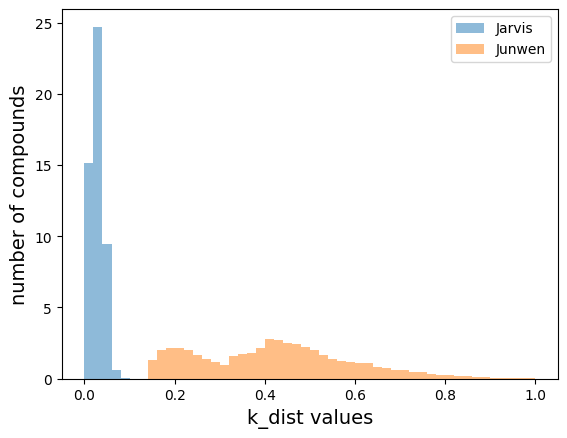

In [20]:
plt.hist(jarvis['k_dist'].values, range=(0,1), bins=50,alpha=0.5, density=True, label='Jarvis')
plt.hist(junwen['k_dist'].values, range=(0,1), bins=50,alpha=0.5, density=True, label='Junwen')
plt.xlabel('k_dist values',fontsize=14)
plt.ylabel('number of compounds',fontsize=14)
plt.legend()
plt.show()

In [6]:
def normalize_formulas(df: pd.DataFrame, formula_column: str = 'formula') -> pd.DataFrame:
    """Normalize chemical formulas to IUPAC format, removing duplicates due to structural representations.

    Args:
        df (pd.DataFrame): DataFrame containing at least a 'formula' column.
        formula_column"""
    formula=[]
    for form in df[formula_column].values:
        formula.append(Composition(Composition(form).get_integer_formula_and_factor()[0]).iupac_formula)
    df[formula_column]=formula
    return df 

In [7]:
jarvis = normalize_formulas(jarvis)

/opt/miniconda3/envs/kpoints/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for He. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/opt/miniconda3/envs/kpoints/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ar. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/opt/miniconda3/envs/kpoints/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ne. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(


In [8]:
junwen = normalize_formulas(junwen, "Formula")

In [9]:
jarvis_formulas=list(set(jarvis['formula'].values))
len(jarvis_formulas)

51889

In [10]:
junwen_formulas=list(set(junwen['Formula'].values))
len(junwen_formulas)

18718

In [12]:
formulas=[]
band_gaps=[]
structures=[]
jarvis_dist=[]
junwen_dist=[]
matcher=StructureMatcher(attempt_supercell=True)
for form in junwen_formulas:
    if form in jarvis_formulas:
        da=jarvis.loc[jarvis['formula']==form]
        db=junwen.loc[junwen['Formula']==form]
        for i in range(len(db)):
            struct1=db['structure'].values[i]
            for struct,k_dist, gap in zip(da['structure'].values,da['k_dist'].values,da['optb88vdw_bandgap'].values):
                if matcher.fit(struct1, struct):
                    formulas.append(form)
                    band_gaps.append(gap)
                    structures.append(struct1)
                    jarvis_dist.append(k_dist)
                    junwen_dist.append(db['k_dist'].values[i])
                

In [61]:
df=pd.DataFrame({
    'formula': formulas,
    'structure': structures,
    'jarvis_kdist': jarvis_dist,
    'junwen_kdist': junwen_dist,
    'optb88vdw_bandgap':band_gaps
    })

In [62]:
da=df.loc[df['optb88vdw_bandgap']==0]
db=df.loc[df['optb88vdw_bandgap']>0]

In [17]:
len(da), len(db)

(4263, 5353)

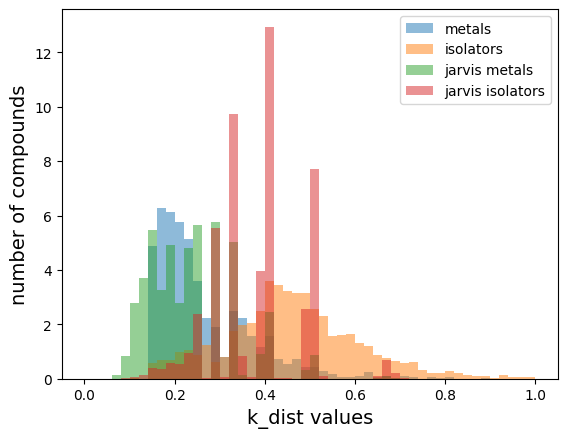

In [65]:
plt.hist(da['junwen_kdist'].values, range=(0,1), bins=50,alpha=0.5, density=True, label='metals')
plt.hist(db['junwen_kdist'].values, range=(0,1), bins=50,alpha=0.5, density=True, label='isolators')
plt.hist(daa['k_dist'].values*10, range=(0,1), bins=50,alpha=0.5, density=True, label='jarvis metals')
plt.hist(dbb['k_dist'].values*10, range=(0,1), bins=50,alpha=0.5, density=True, label='jarvis isolators')
plt.xlabel('k_dist values',fontsize=14)
plt.ylabel('number of compounds',fontsize=14)
plt.legend()
plt.show()

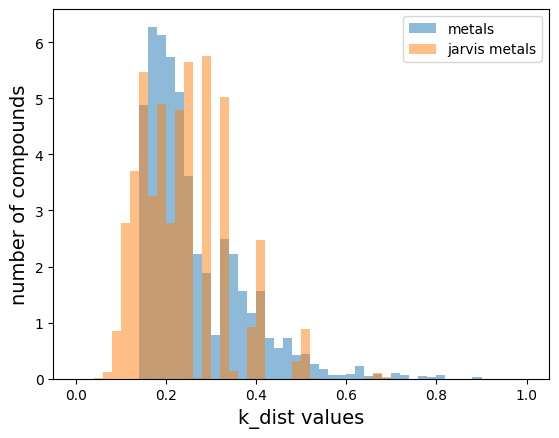

In [66]:
plt.hist(da['junwen_kdist'].values, range=(0,1), bins=50,alpha=0.5, density=True, label='metals')
# plt.hist(db['junwen_kdist'].values, range=(0,1), bins=50,alpha=0.5, density=True, label='isolators')
plt.hist(daa['k_dist'].values*10, range=(0,1), bins=50,alpha=0.5, density=True, label='jarvis metals')
# plt.hist(dbb['k_dist'].values*10, range=(0,1), bins=50,alpha=0.5, density=True, label='jarvis isolators')
plt.xlabel('k_dist values',fontsize=14)
plt.ylabel('number of compounds',fontsize=14)
plt.legend()
plt.show()

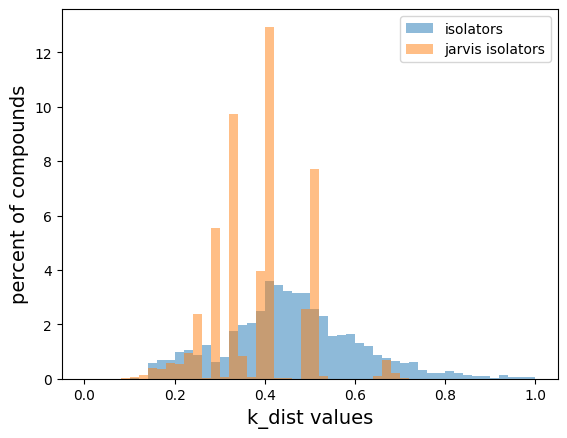

In [68]:
# plt.hist(da['junwen_kdist'].values, range=(0,1), bins=50,alpha=0.5, density=True, label='metals')
plt.hist(db['junwen_kdist'].values, range=(0,1), bins=50,alpha=0.5, density=True, label='isolators')
# plt.hist(daa['k_dist'].values*10, range=(0,1), bins=50,alpha=0.5, density=True, label='jarvis metals')
plt.hist(dbb['k_dist'].values*10, range=(0,1), bins=50,alpha=0.5, density=True, label='jarvis isolators')
plt.xlabel('k_dist values',fontsize=14)
plt.ylabel('percent of compounds',fontsize=14)
plt.legend()
plt.show()

In [60]:
jarvis=jarvis.loc[jarvis['kpoint_length_unit']!='na']
daa=jarvis.loc[jarvis['optb88vdw_bandgap']==0]
dbb=jarvis.loc[jarvis['optb88vdw_bandgap']>0]

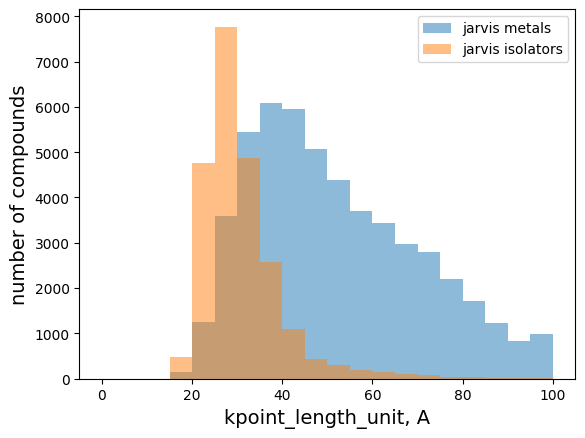

In [58]:
plt.hist(da['kpoint_length_unit'].values, range=(0,100), bins=20,alpha=0.5, density=False, label='jarvis metals')
plt.hist(db['kpoint_length_unit'].values, range=(0,100), bins=20,alpha=0.5, density=False, label='jarvis isolators')
plt.xlabel('kpoint_length_unit, A',fontsize=14)
plt.ylabel('number of compounds',fontsize=14)
plt.legend()
plt.show()

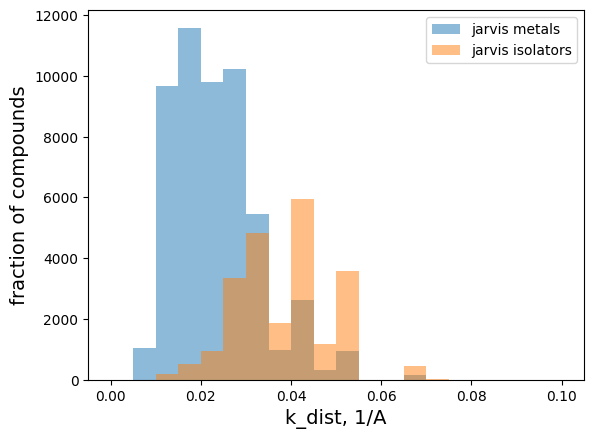

In [55]:
plt.hist(da['k_dist'].values, range=(0,0.1), bins=20,alpha=0.5, density=False, label='jarvis metals')
plt.hist(db['k_dist'].values, range=(0,0.1), bins=20,alpha=0.5, density=False, label='jarvis isolators')
plt.xlabel('k_dist, 1/A',fontsize=14)
plt.ylabel('fraction of compounds',fontsize=14)
plt.legend()
plt.show()

In [14]:
df.to_csv('Comparison_jarvis_junwen.csv')

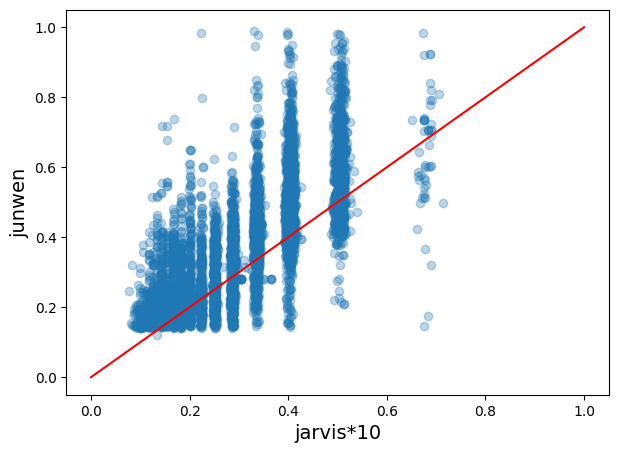

In [54]:
plt.figure(figsize=(7,5))
# sc=plt.scatter(da['jarvis_kdist'].values, da['junwen_kdist'].values, alpha=0.3, label='Jarvis_vs_Junwen_metals')
sc=plt.scatter(df['jarvis_kdist'].values*10, df['junwen_kdist'].values, alpha=0.3, label='Jarvis_vs_Junwen_isolators')
plt.plot([0,1],[0,1], color='red')
plt.xlabel('jarvis*10', fontsize =14)
plt.ylabel('junwen', fontsize = 14)
# plt.legend()
plt.show()

In [10]:
df=pd.read_csv('../data/Comparison_jarvis_junwen.csv')

In [11]:
len(df)

9616